100%|██████████| 426M/426M [00:15<00:00, 29.1MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/buraktaci/multiple-sclerosis/versions/1
Total PNG images found: 3427
Example files: ['/root/.cache/kagglehub/datasets/buraktaci/multiple-sclerosis/versions/1/MS/MS Axial_crop/A1 (46).png', '/root/.cache/kagglehub/datasets/buraktaci/multiple-sclerosis/versions/1/MS/MS Axial_crop/A1 (273).png', '/root/.cache/kagglehub/datasets/buraktaci/multiple-sclerosis/versions/1/MS/MS Axial_crop/A1 (567).png', '/root/.cache/kagglehub/datasets/buraktaci/multiple-sclerosis/versions/1/MS/MS Axial_crop/A1 (8).png', '/root/.cache/kagglehub/datasets/buraktaci/multiple-sclerosis/versions/1/MS/MS Axial_crop/A1 (271).png']
Sample image shape: (433, 396)


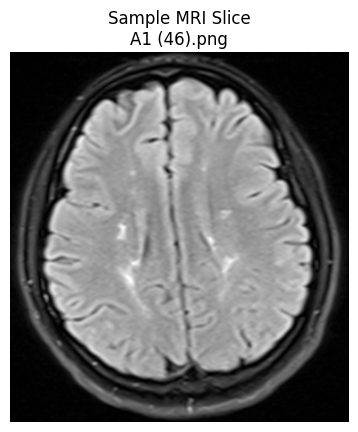


Image counts per folder:
MS Axial_crop: 650 images
MS Saggital_crop: 761 images
Control Saggital_crop: 1014 images
Control Axial_crop: 1002 images


In [1]:
!pip install -q kagglehub matplotlib opencv-python

import kagglehub
import os
import cv2
import matplotlib.pyplot as plt

# ---- Step 1: Download dataset ----
path = kagglehub.dataset_download("buraktaci/multiple-sclerosis")
print("Dataset path:", path)

# ---- Step 2: Find all PNG images ----
png_files = []
for root, dirs, files in os.walk(path):
    for f in files:
        if f.endswith(".png"):
            png_files.append(os.path.join(root, f))

print("Total PNG images found:", len(png_files))
print("Example files:", png_files[:5])

# ---- Step 3: Load one sample image ----
sample_file = png_files[0]
img = cv2.imread(sample_file, cv2.IMREAD_GRAYSCALE)  # MRI slices are grayscale
print("Sample image shape:", img.shape)

plt.imshow(img, cmap="gray")
plt.title(f"Sample MRI Slice\n{os.path.basename(sample_file)}")
plt.axis("off")
plt.show()

# ---- Step 4: Basic dataset stats ----
# Count images per subfolder (could indicate patients or conditions)
from collections import defaultdict

counts = defaultdict(int)
for f in png_files:
    folder = os.path.basename(os.path.dirname(f))
    counts[folder] += 1

print("\nImage counts per folder:")
for k, v in counts.items():
    print(f"{k}: {v} images")


In [2]:
import os
import random
from pathlib import Path
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tqdm.auto import tqdm, trange

# New-style torchvision model import
from torchvision.models import resnet18, ResNet18_Weights


In [4]:
# ---- Hyperparameters ----
DATA_DIR = "/root/.cache/kagglehub/datasets/buraktaci/multiple-sclerosis/versions/1"  # change if needed
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 12
LR = 1e-4
SEED = 42

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = min(4, os.cpu_count() or 1)
PIN_MEMORY = True if DEVICE.type == "cuda" else False

PRINT_EVERY = 20

# reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE.type == "cuda":
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True

In [5]:
# ---- Build file list & label function (with progress) ----
walk_items = list(os.walk(DATA_DIR))
png_files = []
for root, dirs, files in tqdm(walk_items, desc="Scanning dataset folders"):
    for f in files:
        if f.lower().endswith(".png"):
            png_files.append(os.path.join(root, f))

png_files = sorted(png_files)
print(f"\nTotal PNG images found: {len(png_files)}")
assert len(png_files) > 0, "No PNG images found — check DATA_DIR"

def infer_label_from_path(path):
    folder = Path(path).parent.name.lower()
    if "control" in folder or "kontrol" in folder:
        return 0
    else:
        return 1

# class counts (with progress)
counts = defaultdict(int)
for p in tqdm(png_files, desc="Counting classes"):
    counts[infer_label_from_path(p)] += 1
print("Class counts:", dict(counts))  # e.g. {0: 2016, 1: 1411}

# ---- Shuffle & split (80/10/10) ----
random.Random(SEED).shuffle(png_files)

n = len(png_files)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

train_files = png_files[:n_train]
val_files = png_files[n_train:n_train+n_val]
test_files = png_files[n_train+n_val:]

print(f"\nSplit sizes - train: {len(train_files)}, val: {len(val_files)}, test: {len(test_files)}")

Scanning dataset folders:   0%|          | 0/6 [00:00<?, ?it/s]


Total PNG images found: 3427


Counting classes:   0%|          | 0/3427 [00:00<?, ?it/s]

Class counts: {0: 2016, 1: 1411}

Split sizes - train: 2741, val: 342, test: 344


In [6]:
# ---- Dataset class ----
class MSImageDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.files = file_list
        self.transform = transform
        self.labels = [infer_label_from_path(p) for p in file_list]
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        p = self.files[idx]
        img = Image.open(p).convert("RGB")
        if self.transform:
            img = self.transform(img)
        lbl = self.labels[idx]
        return img, lbl

# ---- Transforms ----
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(8),
    transforms.ColorJitter(brightness=0.08, contrast=0.08),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ---- Create datasets & loaders ----
train_ds = MSImageDataset(train_files, transform=train_transform)
val_ds = MSImageDataset(val_files, transform=val_transform)
test_ds = MSImageDataset(test_files, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

In [7]:
# ---- Model (ResNet18 pretrained) ----
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


In [8]:
# ---- Loss, optimizer, scheduler ----
cnt0 = counts.get(0, 1)
cnt1 = counts.get(1, 1)
total = cnt0 + cnt1
class_weights = torch.tensor([ total/(2*cnt0), total/(2*cnt1) ], dtype=torch.float32).to(DEVICE)
print("Class weights:", class_weights.cpu().numpy())

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

Class weights: [0.8499504 1.2143869]


In [9]:
# ---- Training / evaluation helpers with progress bars ----
def train_one_epoch(model, loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []
    pbar = tqdm(enumerate(loader, 1), total=len(loader), desc=f"Epoch {epoch} Train", leave=False)
    for i, (x, y) in pbar:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = out.argmax(dim=1).detach().cpu().numpy()
        all_preds.extend(list(preds))
        all_labels.extend(list(y.detach().cpu().numpy()))

        # update progress postfix
        pbar.set_postfix_str(f"loss: {loss.item():.4f} acc_batch: {accuracy_score(y.cpu().numpy(), preds):.4f}")
    epoch_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, acc

def evaluate(model, loader, criterion, device, phase="Val"):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    pbar = tqdm(enumerate(loader, 1), total=len(loader), desc=f"{phase} Eval", leave=False)
    with torch.no_grad():
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            loss = criterion(out, y)
            running_loss += loss.item() * x.size(0)
            preds = out.argmax(dim=1).detach().cpu().numpy()
            all_preds.extend(list(preds))
            all_labels.extend(list(y.detach().cpu().numpy()))
            pbar.set_postfix_str(f"loss: {loss.item():.4f}")
    epoch_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, acc, all_labels, all_preds

In [10]:
# ---- Training loop (with epoch progress) ----
best_val_acc = 0.0
best_model_path = "best_ms_resnet18.pth"

for epoch in trange(1, NUM_EPOCHS + 1, desc="Epochs"):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE, epoch)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, DEVICE, phase="Val")
    scheduler.step(val_loss)

    tqdm.write(f"Epoch {epoch} summary -> Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        tqdm.write(f"Saved best model -> {best_model_path} (val_acc: {best_val_acc:.4f})")

tqdm.write(f"\nTraining finished. Best val acc: {best_val_acc:.4f}")

Epochs:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1 Train:   0%|          | 0/86 [00:00<?, ?it/s]

Val Eval:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1 summary -> Train loss: 0.3862 | Train acc: 0.8165 | Val loss: 0.2935 | Val acc: 0.8977
Saved best model -> best_ms_resnet18.pth (val_acc: 0.8977)


Epoch 2 Train:   0%|          | 0/86 [00:00<?, ?it/s]

Val Eval:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2 summary -> Train loss: 0.2039 | Train acc: 0.9238 | Val loss: 0.1886 | Val acc: 0.9152
Saved best model -> best_ms_resnet18.pth (val_acc: 0.9152)


Epoch 3 Train:   0%|          | 0/86 [00:00<?, ?it/s]

Val Eval:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3 summary -> Train loss: 0.1521 | Train acc: 0.9464 | Val loss: 0.1314 | Val acc: 0.9474
Saved best model -> best_ms_resnet18.pth (val_acc: 0.9474)


Epoch 4 Train:   0%|          | 0/86 [00:00<?, ?it/s]

Val Eval:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4 summary -> Train loss: 0.1102 | Train acc: 0.9606 | Val loss: 0.1124 | Val acc: 0.9620
Saved best model -> best_ms_resnet18.pth (val_acc: 0.9620)


Epoch 5 Train:   0%|          | 0/86 [00:00<?, ?it/s]

Val Eval:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5 summary -> Train loss: 0.0774 | Train acc: 0.9704 | Val loss: 0.1877 | Val acc: 0.9474


Epoch 6 Train:   0%|          | 0/86 [00:00<?, ?it/s]

Val Eval:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6 summary -> Train loss: 0.0602 | Train acc: 0.9807 | Val loss: 0.1414 | Val acc: 0.9620


Epoch 7 Train:   0%|          | 0/86 [00:00<?, ?it/s]

Val Eval:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7 summary -> Train loss: 0.0630 | Train acc: 0.9774 | Val loss: 0.0906 | Val acc: 0.9678
Saved best model -> best_ms_resnet18.pth (val_acc: 0.9678)


Epoch 8 Train:   0%|          | 0/86 [00:00<?, ?it/s]

Val Eval:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8 summary -> Train loss: 0.0454 | Train acc: 0.9847 | Val loss: 0.1226 | Val acc: 0.9708
Saved best model -> best_ms_resnet18.pth (val_acc: 0.9708)


Epoch 9 Train:   0%|          | 0/86 [00:00<?, ?it/s]

Val Eval:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9 summary -> Train loss: 0.0417 | Train acc: 0.9847 | Val loss: 0.0910 | Val acc: 0.9795
Saved best model -> best_ms_resnet18.pth (val_acc: 0.9795)


Epoch 10 Train:   0%|          | 0/86 [00:00<?, ?it/s]

Val Eval:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10 summary -> Train loss: 0.0525 | Train acc: 0.9799 | Val loss: 0.2610 | Val acc: 0.9444


Epoch 11 Train:   0%|          | 0/86 [00:00<?, ?it/s]

Val Eval:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11 summary -> Train loss: 0.0265 | Train acc: 0.9916 | Val loss: 0.0943 | Val acc: 0.9737


Epoch 12 Train:   0%|          | 0/86 [00:00<?, ?it/s]

Val Eval:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12 summary -> Train loss: 0.0149 | Train acc: 0.9964 | Val loss: 0.0752 | Val acc: 0.9854
Saved best model -> best_ms_resnet18.pth (val_acc: 0.9854)

Training finished. Best val acc: 0.9854


In [11]:
# ---- Load best model & test evaluation (progress shown) ----
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader, criterion, DEVICE, phase="Test")
tqdm.write(f"\nTest loss: {test_loss:.4f} | Test acc: {test_acc:.4f}\n")
tqdm.write("Classification report:\n" + classification_report(y_true, y_pred, digits=4, target_names=["Control","MS"]))

Test Eval:   0%|          | 0/11 [00:00<?, ?it/s]


Test loss: 0.0476 | Test acc: 0.9826

Classification report:
              precision    recall  f1-score   support

     Control     0.9805    0.9901    0.9853       203
          MS     0.9856    0.9716    0.9786       141

    accuracy                         0.9826       344
   macro avg     0.9830    0.9809    0.9819       344
weighted avg     0.9826    0.9826    0.9825       344



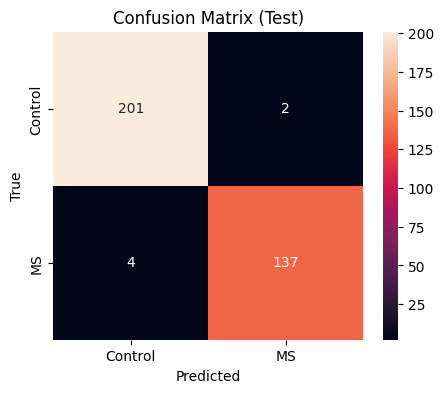

In [12]:
# ---- Confusion matrix ----
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Control","MS"], yticklabels=["Control","MS"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test)")
plt.show()

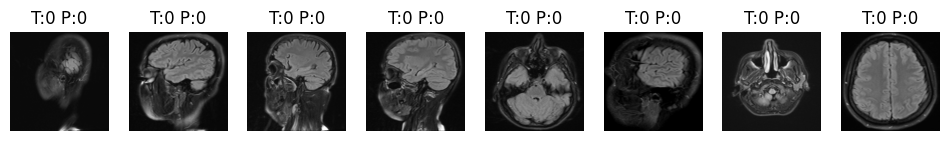

In [13]:
# ---- Show some test predictions (with progress for selection) ----
def show_predictions(loader, model, device, n=8):
    model.eval()
    inv_norm = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    imgs, preds, trues = [], [], []
    with torch.no_grad():
        # iterate with progress until we collect n images
        pbar = tqdm(loader, desc="Collecting sample predictions")
        for x, y in pbar:
            out = model(x.to(device))
            p = out.argmax(dim=1).cpu().numpy()
            for i in range(x.size(0)):
                imgs.append(x[i])
                preds.append(int(p[i]))
                trues.append(int(y[i].item()))
                if len(imgs) >= n:
                    break
            if len(imgs) >= n:
                break

    plt.figure(figsize=(12,3))
    for i in range(len(imgs)):
        im = inv_norm(imgs[i]).permute(1,2,0).cpu().numpy().clip(0,1)
        plt.subplot(1, n, i+1)
        plt.imshow(im)
        plt.title(f"T:{trues[i]} P:{preds[i]}")
        plt.axis('off')
    plt.show()

show_predictions(test_loader, model, DEVICE, n=8)